In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# DataBlock API
> Rethinking Data preprocessing

In [2]:
#export
from exp.nb_08 import *

In [3]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160'

## Data Pipeline

Thus far we've been working with MNIST. We're going to now work with a more challenging dataset and therefore will need to rethink how we are loading our data. MNIST is good to toy around with but its also very small. 


Our data pipeline needs to accomplish these tasks:

- Get files into a container
- Split validation set by some criterion:
  - random percent
  - folder name
  - row or column of csv
  - etc.
- Label: 
  - folder name 
  - file name/re
  - row or column of csv
  - etc. 
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

### Get Files 

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160); path

WindowsPath('D:/_DATA/fastai/data/imagenette2-160')

In [8]:
#export 
import PIL, os, mimetypes
from pathlib import Path

Path.ls = lambda x: list(x.iterdir())

In [9]:
path.ls()

[WindowsPath('D:/_DATA/fastai/data/imagenette2-160/train'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val')]

In [10]:
(path/'val').ls()

[WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n01440764'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n02102040'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n02979186'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n03000684'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n03028079'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n03394916'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n03417042'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n03425413'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n03445777'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n03888257')]

In [11]:
path_tench = path/'val'/'n01440764'

In [14]:
img_path = path_tench.ls()[0]

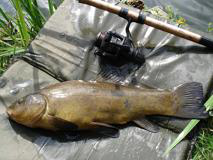

In [17]:
img = PIL.Image.open(img_path); img

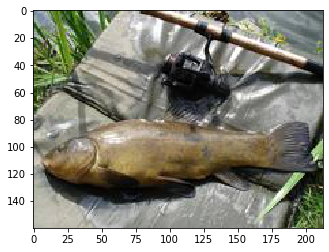

In [18]:
plt.imshow(img)

In [21]:
import numpy

imga = numpy.array(img); imga.shape

(160, 213, 3)

In [25]:
imga[:10, :10, 0]

array([[126, 127, 136, 150, ..., 172, 180, 171, 107],
       [130, 125, 129, 143, ..., 162, 162, 142, 161],
       [120, 119, 124, 132, ..., 143, 145, 153, 187],
       [114, 122, 129, 129, ..., 132, 142, 175, 166],
       ...,
       [153, 149, 141, 131, ..., 128, 122, 136, 148],
       [136, 150, 157, 144, ..., 131, 138, 154, 130],
       [ 57, 141, 165, 155, ..., 128, 145, 135, 140],
       [ 42,  80, 145, 137, ..., 142, 138, 138, 131]], dtype=uint8)

In [43]:
#export
image_extension = set(k for k,v in mimetypes.types_map.items() if v.startswith('image'))

In [49]:
#export
def setify(x): return x if isinstance(x, set) else set(listify(x))

In [50]:
setify(['a','b','a'])

{'a', 'b'}

In [54]:
test_eq({'a','a','b'}, setify(['a','a','b']))
test_eq({'a',1}, setify(['a',1]))

This `_get_files` 

In [70]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    # path / filename  if it does not start with a '.' and (no extensions are given OR the suffix is in extensions)
    res = [p/f for f in fs if not f.startswith('.') and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [78]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path_tench, t, image_extension)

t[:3]

[WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00009111.JPEG'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00009191.JPEG'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00017472.JPEG')]

Now let's write a recursive function that will go through a folder and subfolders and return a list of image files:

In [93]:
#export

def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    
    if recurse:
        res = []
        #dirpath, dirnames, filenames
        for i,(p,d,f) in enumerate(os.walk(path)): 
            if include is not None and i==0: 
                d[:] = [o for o in d if o in include]
            else:                            
                d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
        
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions=extensions)

In [94]:
get_files(path_tench, extensions=image_extension)[:3]

[WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00009111.JPEG'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00009191.JPEG'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00017472.JPEG')]

But if we just give it our original `path` we'll need it to recursively go through each subfolder:

In [96]:
get_files(path, extensions=image_extension, recurse=True)[:3]

[WindowsPath('D:/_DATA/fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG'),
 WindowsPath('D:/_DATA/fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG')]

In [97]:
all_imgs = get_files(path, extensions=image_extension, recurse=True)

In [98]:
len(all_imgs)

13394

In [100]:
%timeit -n 10 get_files(path, image_extension, recurse=True)

60.8 ms ± 853 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### ItemList and ImageList

In [ ]:
nb_auto_export()